In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('MNRAS')
from scipy import linalg
from scipy.interpolate import interp1d

In [23]:
## make the fake data
lam = [20, 30, 45, 60, 1000]
z_data = [0.2, 0.35, 0.5, 0.65]
z_sim = [0.3, 0.4, 0.5]

for iz in range(3):
    
    redshift = z_sim[iz]
    
    if redshift == 0.3: z_str = '0p300'
    if redshift == 0.4: z_str = '0p400'
    if redshift == 0.5: z_str = '0p500'
    
    data_loc = '/projects/hywu/cluster_sims/cluster_finding/data/emulator_data/base_c000_ph000/'
    data_loc += f'z{z_str}/model_hod000000/obs_q180_desy1/'
    # get the radius
    rp_list = np.logspace(np.log10(0.03), np.log10(30), 15+1)
    rpmin_list = rp_list[:-1]
    rpmax_list = rp_list[1:]
    rpmid_list = np.sqrt(rpmin_list*rpmax_list)
    rp_rad = rpmid_list[rpmid_list>0.2]
    
    #### lesing data ####
    DS_data = []
    for ilam in range(4):
        rp_in, DS_in = np.loadtxt(data_loc + f'DS_phys_noh_lam_bin_{ilam}.dat', unpack=True)
        DS_interp = interp1d(np.log(rp_in), np.log(DS_in))
        DS_data.extend(np.exp(DS_interp(np.log(rp_rad))))
    DS_data = np.array(DS_data)
    
    #### lensing cov ####
    cov_loc = '/users/hywu/work/cluster-lensing-cov-public/examples/abacus_summit_analytic/'
    for ilam in range(4):    
        rp_cov = np.loadtxt(cov_loc + f'rp_phys_noh_{z_data[iz]}_{z_data[iz+1]}_{lam[ilam]}_{lam[ilam+1]}.dat')
        
        print('check radius difference', '%.2g'%max(abs(rp_cov[4:]/rp_rad - 1)))
        print(rp_cov[4:])
        print(rp_rad)
        
        data = np.loadtxt(cov_loc + f'DeltaSigma_cov_combined_phys_noh_{z_data[iz]}_{z_data[iz+1]}_{lam[ilam]}_{lam[ilam+1]}.dat')
        data = data[4:,4:]
        if ilam == 0:
            cov_DS = data * 1.
        else:
            cov_DS = linalg.block_diag(cov_DS, data)
    print('np.shape(cov_DS)', np.shape(cov_DS))
    cov_DS_inv = linalg.inv(cov_DS)
    
    
    #### counts data ####
    x, x, NC_data = np.loadtxt(data_loc+'abundance.dat',unpack=True)
    
    #### counts cov ####
    cov_NC = []
    for ilam in range(4):    
        counts, sv, bias, lnM_mean = np.loadtxt(cov_loc + f'counts_{z_data[iz]}_{z_data[iz+1]}_{lam[ilam]}_{lam[ilam+1]}.dat')
        cov_NC.append(counts + sv)
    cov_NC = np.diag(cov_NC)
    cov_NC_inv = linalg.inv(cov_NC)
    
    
    #### combine counts and lensing 
    data_vec = np.append(NC_data, DS_data)
    from scipy.linalg import block_diag
    cov = block_diag(cov_NC, cov_DS)
    cov_inv = block_diag(cov_NC_inv, cov_DS_inv)
    
    print('np.shape(cov_inv)', np.shape(cov_inv))
    
    np.savetxt(f'data_vector_abacus_summit/data_vector_z{redshift}.dat', data_vec)
    np.savetxt(f'data_vector_abacus_summit/cov_inv_z{redshift}.dat', cov_inv)
    np.savetxt(f'data_vector_abacus_summit/cov_z{redshift}.dat', cov)

11
check radius difference 0.062
[ 0.25319212  0.40128248  0.63598986  1.007976    1.59753431  2.53192125
  4.01282475  6.35989863 10.07976004 15.97534307 25.31921248]
[ 0.23829847  0.37767762  0.59857869  0.9486833   1.5035617   2.3829847
  3.77677624  5.98578694  9.48683298 15.03561701 23.82984704]
check radius difference 0.062
[ 0.25319212  0.40128248  0.63598986  1.007976    1.59753431  2.53192125
  4.01282475  6.35989863 10.07976004 15.97534307 25.31921248]
[ 0.23829847  0.37767762  0.59857869  0.9486833   1.5035617   2.3829847
  3.77677624  5.98578694  9.48683298 15.03561701 23.82984704]
check radius difference 0.062
[ 0.25319212  0.40128248  0.63598986  1.007976    1.59753431  2.53192125
  4.01282475  6.35989863 10.07976004 15.97534307 25.31921248]
[ 0.23829847  0.37767762  0.59857869  0.9486833   1.5035617   2.3829847
  3.77677624  5.98578694  9.48683298 15.03561701 23.82984704]
check radius difference 0.062
[ 0.25319212  0.40128248  0.63598986  1.007976    1.59753431  2.531921

In [3]:
# # check radius!
# rp_rad = np.loadtxt(f'/projects/hywu/cluster_sims/cluster_finding/data/emulator_train/train/rp_rad.dat')

# rp_cov = np.loadtxt(cov_loc + 'rp_hiMpc_0.35_0.5_60_1000.dat')[:,2] * a / h
# print((rp_cov[4:] - rp_rad)/rp_rad) #okay!

frac noise: DS [0.09550111 0.08893924 0.08833378 0.09297867 0.11083739 0.14142981
 0.15602101 0.15104581 0.1417817  0.14077622 0.15788741]
frac noise: DS [0.09864905 0.08761144 0.08334611 0.08358788 0.09254277 0.11430243
 0.13456616 0.14207542 0.14232774 0.14625799 0.16614276]
frac noise: DS [0.12763033 0.10841337 0.09905008 0.09562069 0.10070666 0.12103773
 0.14764721 0.16675144 0.17800941 0.19121667 0.21955762]
frac noise: DS [0.10189528 0.08202662 0.07123541 0.06582663 0.06587395 0.07609311
 0.0959801  0.11647849 0.13209723 0.14855006 0.17947418]
frac noise: NC [0.0175447  0.03118481 0.06686312 0.11222373]
frac noise: DS [0.1254664  0.11685307 0.11608234 0.12227149 0.14608007 0.18766953
 0.21111394 0.21488798 0.22398304 0.26122254 0.34966963]
frac noise: DS [0.13408688 0.11909177 0.11331782 0.11372527 0.12618662 0.15691199
 0.18834429 0.20896017 0.23205261 0.27918728 0.37729434]
frac noise: DS [0.17992522 0.15284402 0.13967288 0.13493013 0.14241952 0.1723264
 0.21430425 0.25423084 0

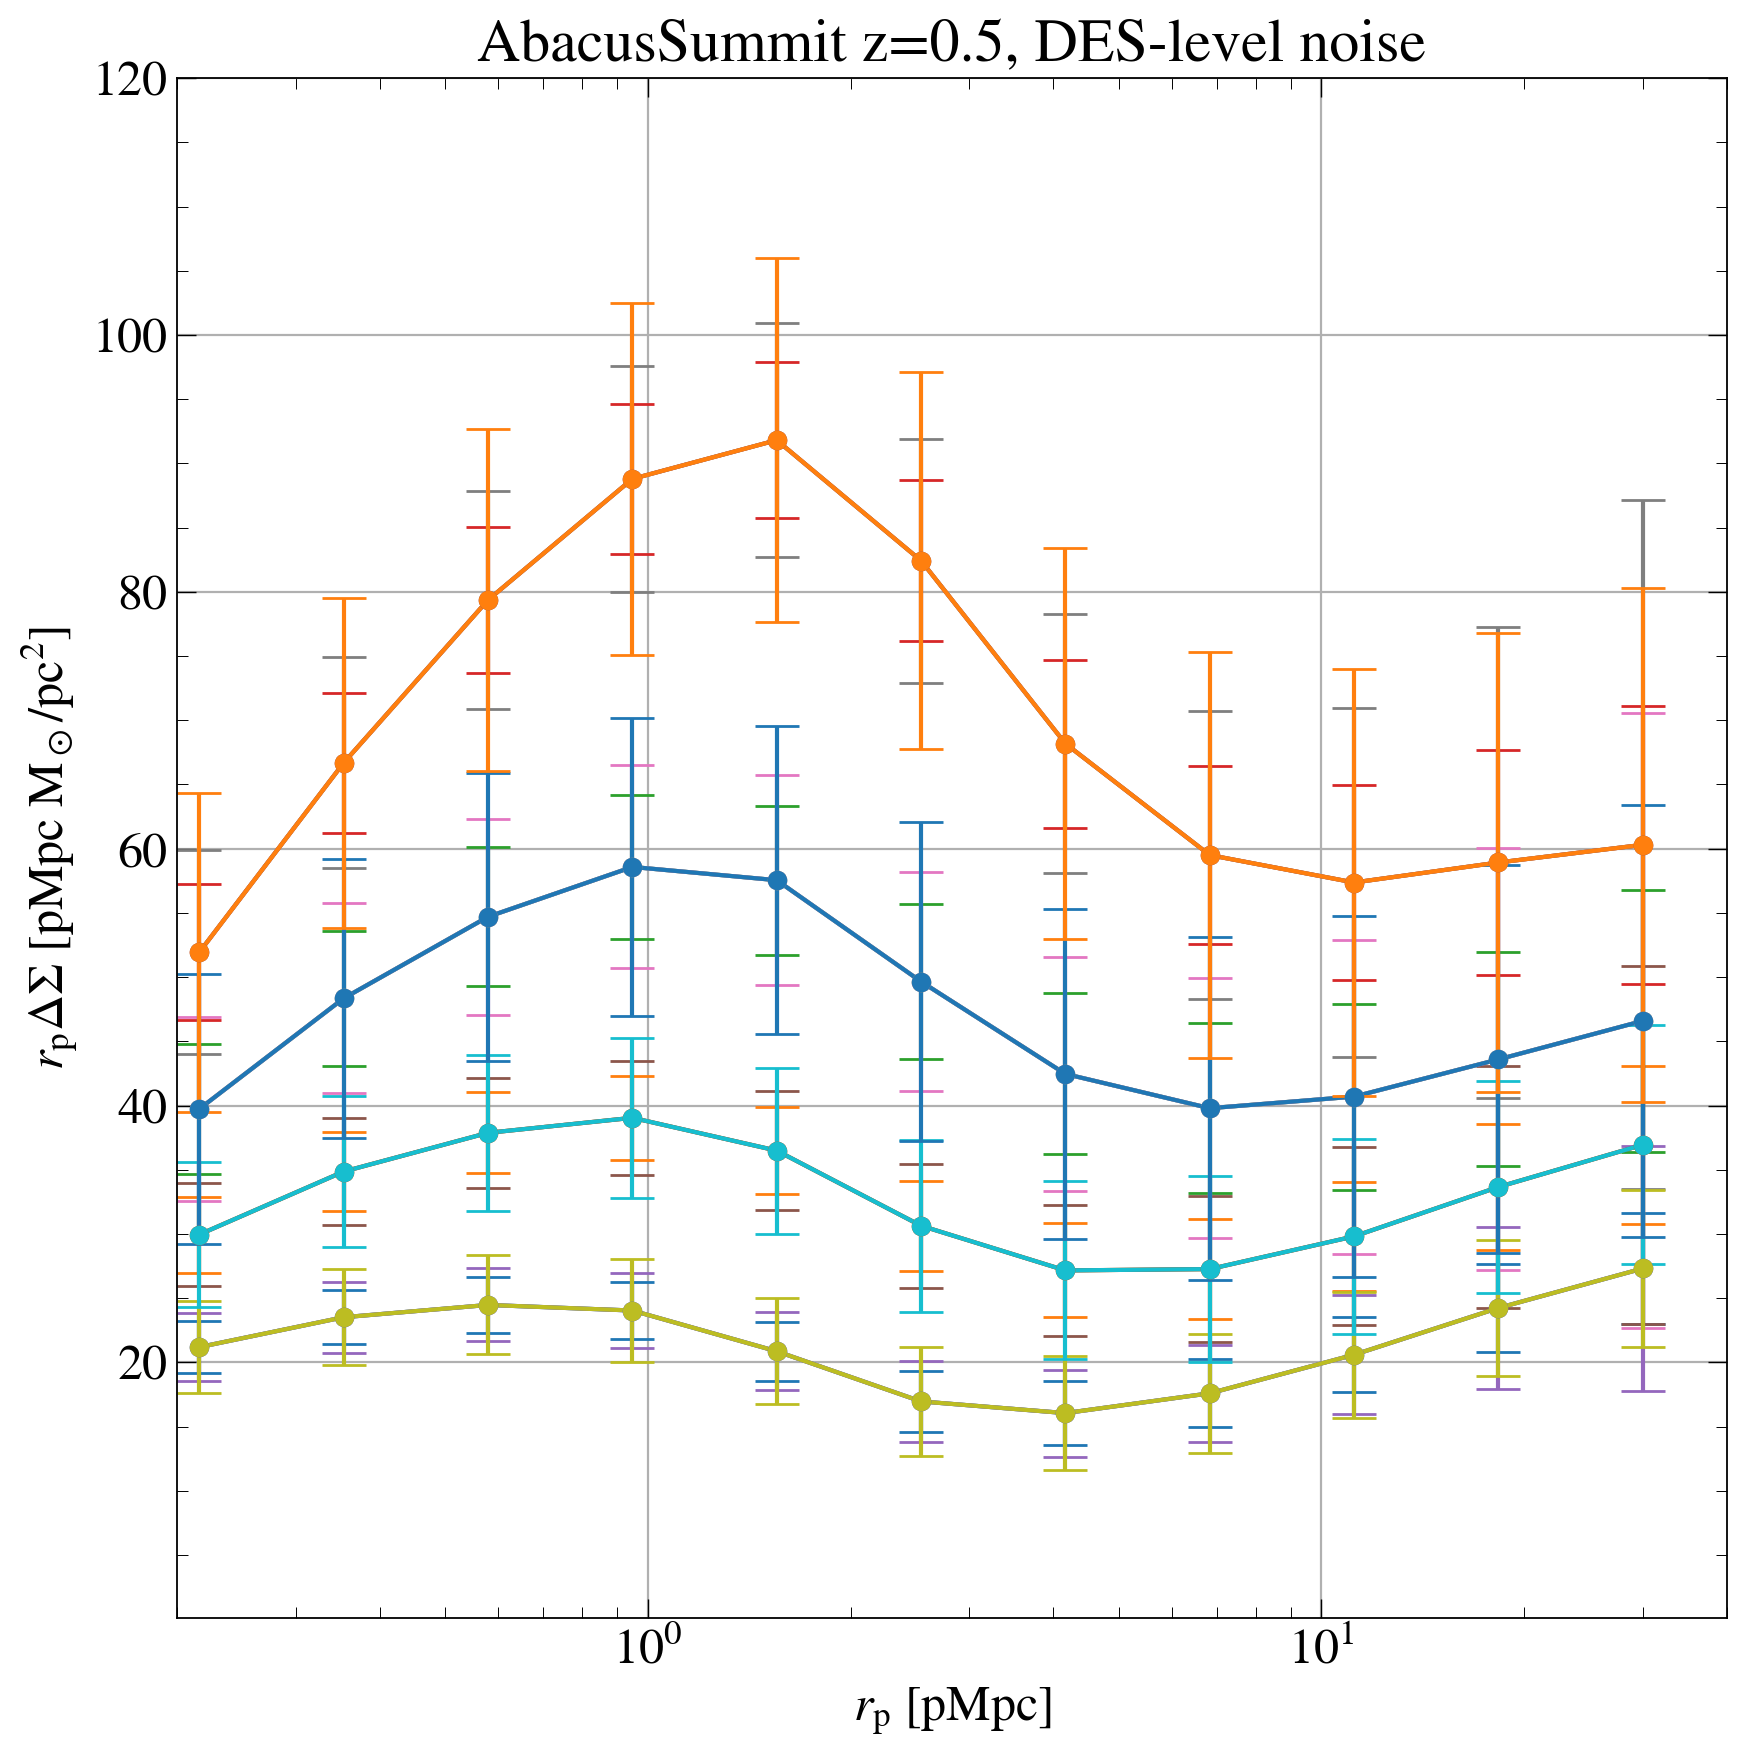

In [5]:
# plot the fake data and error bars
#plt.figure(figsize=(21,7))
plt.figure(figsize=(10,10))
cov_loc = '/users/hywu/work/cluster-lensing-cov-public/examples/abacus_summit_analytic/'
for iz in range(3):
    #plt.subplot(1,3,1+iz)
    
    redshift = z_sim[iz]
    data_loc = '/projects/hywu/cluster_sims/cluster_finding/data/emulator_data/base_c000_ph000/'
    data_loc += f'z{z_str}/model_hod000000/obs_q180_desy1/'

    for ilam in range(4):
        rp_in, DS_in = np.loadtxt(data_loc + f'DS_phys_noh_lam_bin_{ilam}.dat', unpack=True)
        DS_interp = interp1d(np.log(rp_in), np.log(DS_in))
        DS_data = np.exp(DS_interp(np.log(rp_rad)))
    
        cov = np.loadtxt(cov_loc + f'DeltaSigma_cov_combined_phys_noh_{z_data[iz]}_{z_data[iz+1]}_{lam[ilam]}_{lam[ilam+1]}.dat')
        sig = np.sqrt(np.diag(cov))[4:]
        line = plt.plot(rp_rad, rp_rad*DS_data)
        co = line[0].get_c()
        plt.errorbar(rp_rad, rp_rad*DS_data, rp_rad*sig, 
                     label='data', c=co, marker='o', mec=co, ls='', capsize=8)#, np.diag(cov))
        plt.xscale('log')
        print('frac noise: DS', sig/DS_data)
    
    plt.xlim(0.2, 40)
    plt.ylim(0.10, 120)
    plt.title(f'AbacusSummit z={redshift}, DES-level noise')
    
    plt.xlabel(r'$r_{\rm p}~[{\rm pMpc}]$')
    plt.ylabel(r'$r_{\rm p} \Delta\Sigma~[{\rm pMpc ~M_\odot/pc^2} ]$')
    sig_NC = np.sqrt(np.diag(cov_NC))
    print('frac noise: NC',sig_NC/NC_data)
#plt.savefig(f'../../plots/emulator/abacus_summit_fid_lensing.pdf')